# conds

In [1]:
import numpy as np
import kwant
from numpy import sqrt,pi,kron
import matplotlib.pyplot as plt
import time
from numpy import sqrt,pi,cos,sin,kron
from scipy.sparse.linalg import eigsh



#pauli matrix
sigma_0 = np.array([[1, 0],[0, 1]])
sigma_x = np.array([[0, 1],[1, 0]])
sigma_y = np.array([[0, -1j],[1j, 0]])
sigma_z = np.array([[1, 0],[0, -1]])

tau_0 = sigma_0
tau_x = sigma_x
tau_y = sigma_y
tau_z = sigma_z

L = 300
delta = 1
tw = 12
ts = 6
mu_s = 0.4
Zs = 0
alpha = 0.8
T = 0.4



def BdG_conds_1D(Zw, mu_w, t_lead = tw, mu_lead = 2*tw):
    sys = kwant.Builder()
    wire_lat = kwant.lattice.square(a=1,norbs = 4, name = 'wire')
    sc_lat = kwant.lattice.square(a=1,norbs = 4, name = 'sc')

    #wire onsite
    sys[ (wire_lat(i,0) for i in range(L+1))] = (2 * tw - mu_w) * kron(tau_z, sigma_0) + Zw * kron(tau_0, sigma_x)

    #wire hopping
    sys[kwant.builder.HoppingKind((1, 0), wire_lat)] = -tw * kron(tau_z, sigma_0) + 1j * alpha / 2 * kron(tau_z, sigma_y)


    #left lead
    left = kwant.Builder(kwant.TranslationalSymmetry((-1,0)))
    left[wire_lat(0, 0)] =  (2 * t_lead - mu_lead) * kron(tau_z,sigma_0)
    left[kwant.builder.HoppingKind((-1, 0), wire_lat)] = -t_lead * kron(tau_z,sigma_0)
    sys.attach_lead(left)

    #rignt lead
    rignt = kwant.Builder(kwant.TranslationalSymmetry((1,0)))
    rignt[wire_lat(L, 0)] =  (2 * t_lead - mu_lead) * kron(tau_z,sigma_0)
    rignt[kwant.builder.HoppingKind((-1, 0), wire_lat)] = -t_lead * kron(tau_z,sigma_0)
    sys.attach_lead(rignt)

    #sc
    sys[ (sc_lat(i,-1) for i in range(L+1))] = (2 * ts - mu_s) * kron(tau_z, sigma_0) + delta * kron(tau_x, sigma_0) + Zs * kron(tau_0, sigma_x)
    sys[kwant.builder.HoppingKind((1,0),sc_lat)] = -ts * kron(tau_z, sigma_0) 

    #tunneling 
    sys[kwant.builder.HoppingKind((0,1),wire_lat,sc_lat)] = T * kron(tau_z,sigma_0)
    return sys




def local_cond(S):
    ree = np.sum(np.abs(S[:len(S)//2, :len(S)//2])**2)
    reh = np.sum(np.abs(S[:len(S)//2, len(S)//2:])**2)
    return (len(S)//2 - ree + reh)


def nonlocal_cond(S):
    ree = np.sum(np.abs(S[:len(S)//2, :len(S)//2])**2)
    reh = np.sum(np.abs(S[:len(S)//2, len(S)//2:])**2)
    return (ree - reh)


def cal_conds(sys,energys):
    smatrix = kwant.smatrix(sys,energy=energys,check_hermiticity=True)
    GLL=local_cond(np.array(smatrix.submatrix(0,0)))
    GLR=nonlocal_cond(np.array(smatrix.submatrix(0,1)))
    return GLL,GLR




# 1D conds

e:\anaconda3\envs\kwant\Lib\site-packages\kwant\_plotter.py:77: RuntimeWarning: plotly is not available, if other engines are unavailable, only iterator-providing functions will work
  warnings.warn("plotly is not available, if other engines are unavailable,"


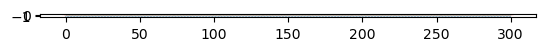

2.461925745010376


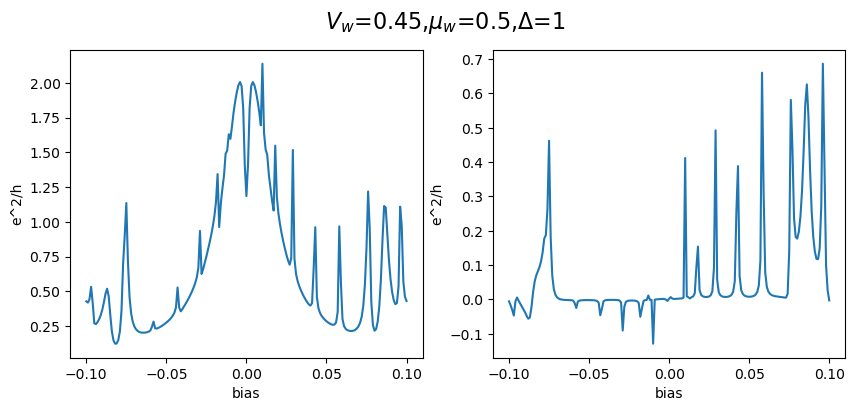

In [ ]:
Zw = 0.45
mu_w = 0.5
bias_range = np.linspace(-0.1,0.1,201)


system = BdG_conds_1D(Zw, mu_w)
system = system.finalized()
kwant.plot(system)

# conds
t1 = time.time()
GLL = np.zeros(len(bias_range))
GLR = np.zeros(len(bias_range))

for i in range(len(bias_range)):
    GLL[i], GLR[i] = cal_conds(system,bias_range[i])

t2 = time.time()
print(t2-t1)

plt.figure(figsize=(10,4))
plt.suptitle(f'$V_w$={Zw},$\\mu_w$={mu_w},$\\Delta$={delta}', fontsize=16)
plt.subplot(1,2,1)
plt.plot(bias_range, GLL, label="GLL")
plt.xlabel('bias')
plt.ylabel('e^2/h')

plt.subplot(1,2,2)
plt.plot(bias_range, GLR, label="GLR")
plt.xlabel('bias')
plt.ylabel('e^2/h')
plt.show()

# 2D conds

213.39693999290466


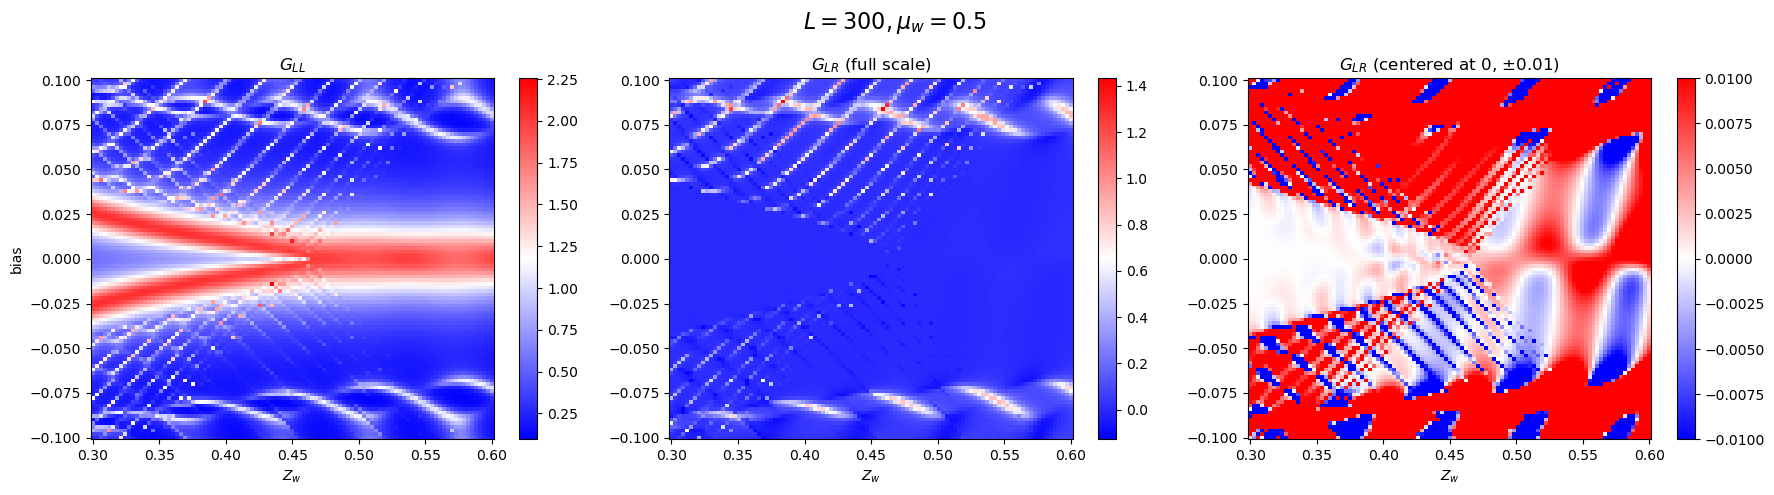

In [10]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

Zw_range = np.linspace(0.3,0.6,101)
bias_range = np.linspace(-0.1,0.1,101)

mu_w = 0.5

t1 = time.time()
GLL = np.zeros((len(Zw_range),len(bias_range)))
GLR = np.zeros((len(Zw_range),len(bias_range)))

for i in range(len(Zw_range)):
    for j in range(len(bias_range)):
        system = BdG_conds_1D(Zw_range[i],mu_w = mu_w).finalized()
        GLL[i][j], GLR[i][j] = cal_conds(system,bias_range[j])

t2 = time.time()
print(t2-t1)


def plot_cond(x, y, GLL, GLR):
    X, Y = np.meshgrid(x, y)
    Z1 = np.array(GLL).T
    Z2 = np.array(GLR).T

    plt.figure(figsize=(18, 5))
    plt.suptitle(f"$L={L},\\mu_w={mu_w}$", fontsize=16)

    # --- GLL ---
    plt.subplot(1, 3, 1)
    plt.pcolormesh(X, Y, Z1, cmap='bwr', shading='auto')
    plt.xlabel('$Z_w$')
    plt.ylabel('bias')
    plt.title("$G_{LL}$")
    plt.colorbar()

    # --- GLR (full scale) ---
    plt.subplot(1, 3, 2)
    plt.pcolormesh(X, Y, Z2, cmap='bwr', shading='auto')
    plt.xlabel('$Z_w$')
    plt.title("$G_{LR}$ (full scale)")
    plt.colorbar()

    # --- GLR (restricted range, centered at 0) ---
    plt.subplot(1, 3, 3)
    norm = mcolors.TwoSlopeNorm(vmin=-0.01, vcenter=0, vmax=0.01)
    plt.pcolormesh(X, Y, Z2, cmap='bwr', shading='auto', norm=norm)
    plt.xlabel('$Z_w$')
    plt.title("$G_{LR}$ (centered at 0, ±0.01)")
    plt.colorbar()

    plt.tight_layout()
    plt.show()



plot_cond(Zw_range, bias_range, GLL, GLR)

# $\mu$,bias

324.1263737678528


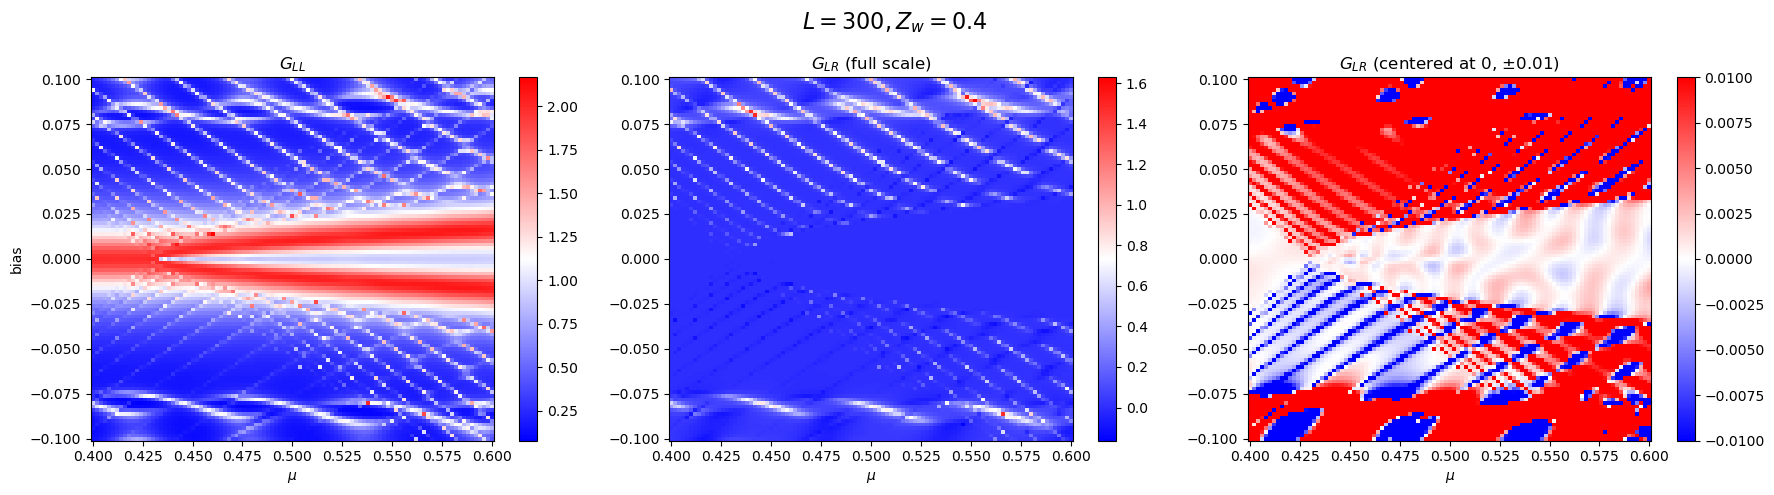

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

Zw = 0.4

mu_w_range = np.linspace(0.4,0.6,101)
bias_range = np.linspace(-0.1,0.1,101)

t1 = time.time()
GLL = np.zeros((len(mu_w_range),len(bias_range)))
GLR = np.zeros((len(mu_w_range),len(bias_range)))

for i in range(len(mu_w_range)):
    for j in range(len(bias_range)):
        system = BdG_conds_1D(Zw=Zw,mu_w=mu_w_range[i]).finalized()
        GLL[i][j], GLR[i][j] = cal_conds(system,bias_range[j])

t2 = time.time()
print(t2-t1)




def plot_cond(x, y, GLL, GLR):
    X, Y = np.meshgrid(x, y)
    Z1 = np.array(GLL).T
    Z2 = np.array(GLR).T

    plt.figure(figsize=(18, 5))
    plt.suptitle(f"$L={L},Z_w={Zw}$", fontsize=16)

    # --- GLL ---
    plt.subplot(1, 3, 1)
    plt.pcolormesh(X, Y, Z1, cmap='bwr', shading='auto')
    plt.xlabel('$\\mu$')
    plt.ylabel('bias')
    plt.title("$G_{LL}$")
    plt.colorbar()

    # --- GLR (full scale) ---
    plt.subplot(1, 3, 2)
    plt.pcolormesh(X, Y, Z2, cmap='bwr', shading='auto')
    plt.xlabel('$\\mu$')
    plt.title("$G_{LR}$ (full scale)")
    plt.colorbar()

    # --- GLR (restricted range, centered at 0) ---
    plt.subplot(1, 3, 3)
    norm = mcolors.TwoSlopeNorm(vmin=-0.01, vcenter=0, vmax=0.01)
    plt.pcolormesh(X, Y, Z2, cmap='bwr', shading='auto', norm=norm)
    plt.xlabel('$\\mu$')
    plt.title("$G_{LR}$ (centered at 0, ±0.01)")
    plt.colorbar()

    plt.tight_layout()
    plt.show()



plot_cond(mu_w_range,bias_range,GLL,GLR)